# Principle Landmarks

For this LBA you will need to take at least 20 photos of your favorite landmark. These photos need to be as close to identical as possible, but they need to be taken during the day and over a period of at least 4 hours. Something that creates a time-lapse of your favorite landmark would be ideal, but is not necessary.

**Core assignment: **

In [1]:
from PIL import Image
from resizeimage import resizeimage
from glob import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
import PIL

## **Processes all photos down to a size not exceeding 512 pixels in either width or height**

In [2]:
#https://pillow.readthedocs.io/en/latest/reference/ImageOps.html#PIL.ImageOps.exif_transpose

/var/folders/cy/_ctynfc519bgs7b5np9zv9b00000gn/T/ipykernel_17107/364377242.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flattened = np.asarray(flattened)
/Users/hugo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Total Images: 28
Images Shape: (28, 786432)


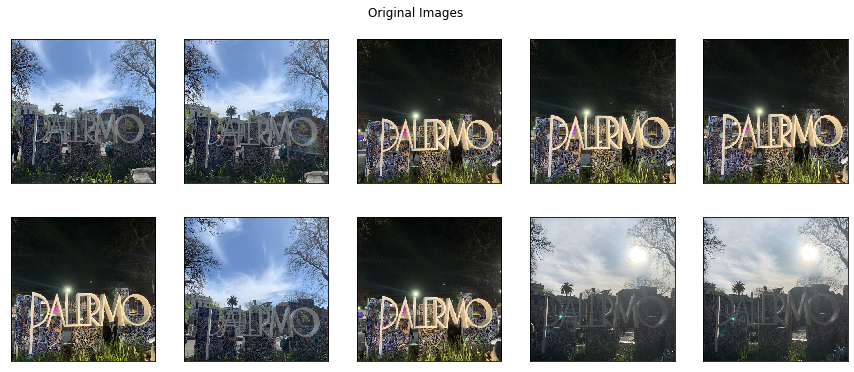

In [3]:
# resize and crop images
def resize_images(images):
    '''
    Resizes and crops images using the function given
    in the Session 7 repo from load_images.py.
    '''    

    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # rotate image to correct direction
                image = PIL.ImageOps.exif_transpose(image)
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, [512,512])
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))


    # Flatten it once more
    flattened = np.asarray(flattened)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    # return resized images
    return X, Y

# resize images using function
file = glob('palermo.image/*')
images = resize_images(file)[0]

print(f'Total Images: {len(images)}')
print(f'Images Shape: {images.shape}')

# plot samples of original images
fig = plt.figure(figsize=(15, 6)) 

for i in range(10): 
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[]) 
    img = Image.fromarray(images[i].reshape(512,512,3), 'RGB') 
    ax.imshow(img, interpolation='nearest') 
    
plt.suptitle('Original Images', y=0.95)

plt.show()

### Comments:

Extra steps are done to rotate the image by 90 degrees anti-clockwise in line 27 to make image vertical. 

## **Using principal components analysis (PCA) project your images down to a 2 dimensional representation**

In [4]:
# apply PCA using top 2 components
n_components = 2 #dimensions
pca = decomposition.PCA(n_components=n_components) #decomposes by n_components variables

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

## **Visually inspect the 2D locations of each photo in the new space**

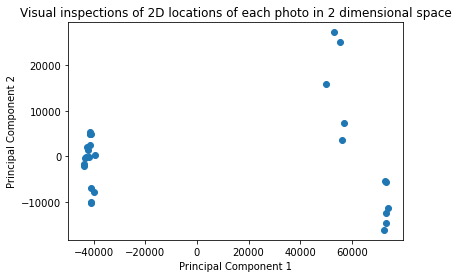

In [5]:
#Plot scatter plot of first two principal components of 2D locations
df = pd.DataFrame(transformed)
plt.scatter(df[0],df[1])
plt.title("Visual inspections of 2D locations of each photo in 2 dimensional space")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Comments
The visual inspections for different principal components are very different given different time of the day. The points of the left are photos taken when it is dark, and points on the right are during the day. This shows how the principal components are affected by time of day greatly, due to the difference background of night and day. 

To visually contrast the difference of each photo from its original after only plotting 2 dimensions, I plotted the difference of each photo. Only the first five are printed here for simplicity.

In [6]:
#For each photo, we plot its 2-dimensional counterpart from its first two principal components
samples = []
title = []
for i in range(0,len(images),1):
    
    samples.append(images[i])
    title.append(f'Original Photo {i+1}')
    
    # apply PCA
    pca = decomposition.PCA(n_components=2)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(images)
    
     # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    sample = formatted[i]
    
    # save results
    samples.append(sample)
    title.append(f'Transformed Photo {i+1}')


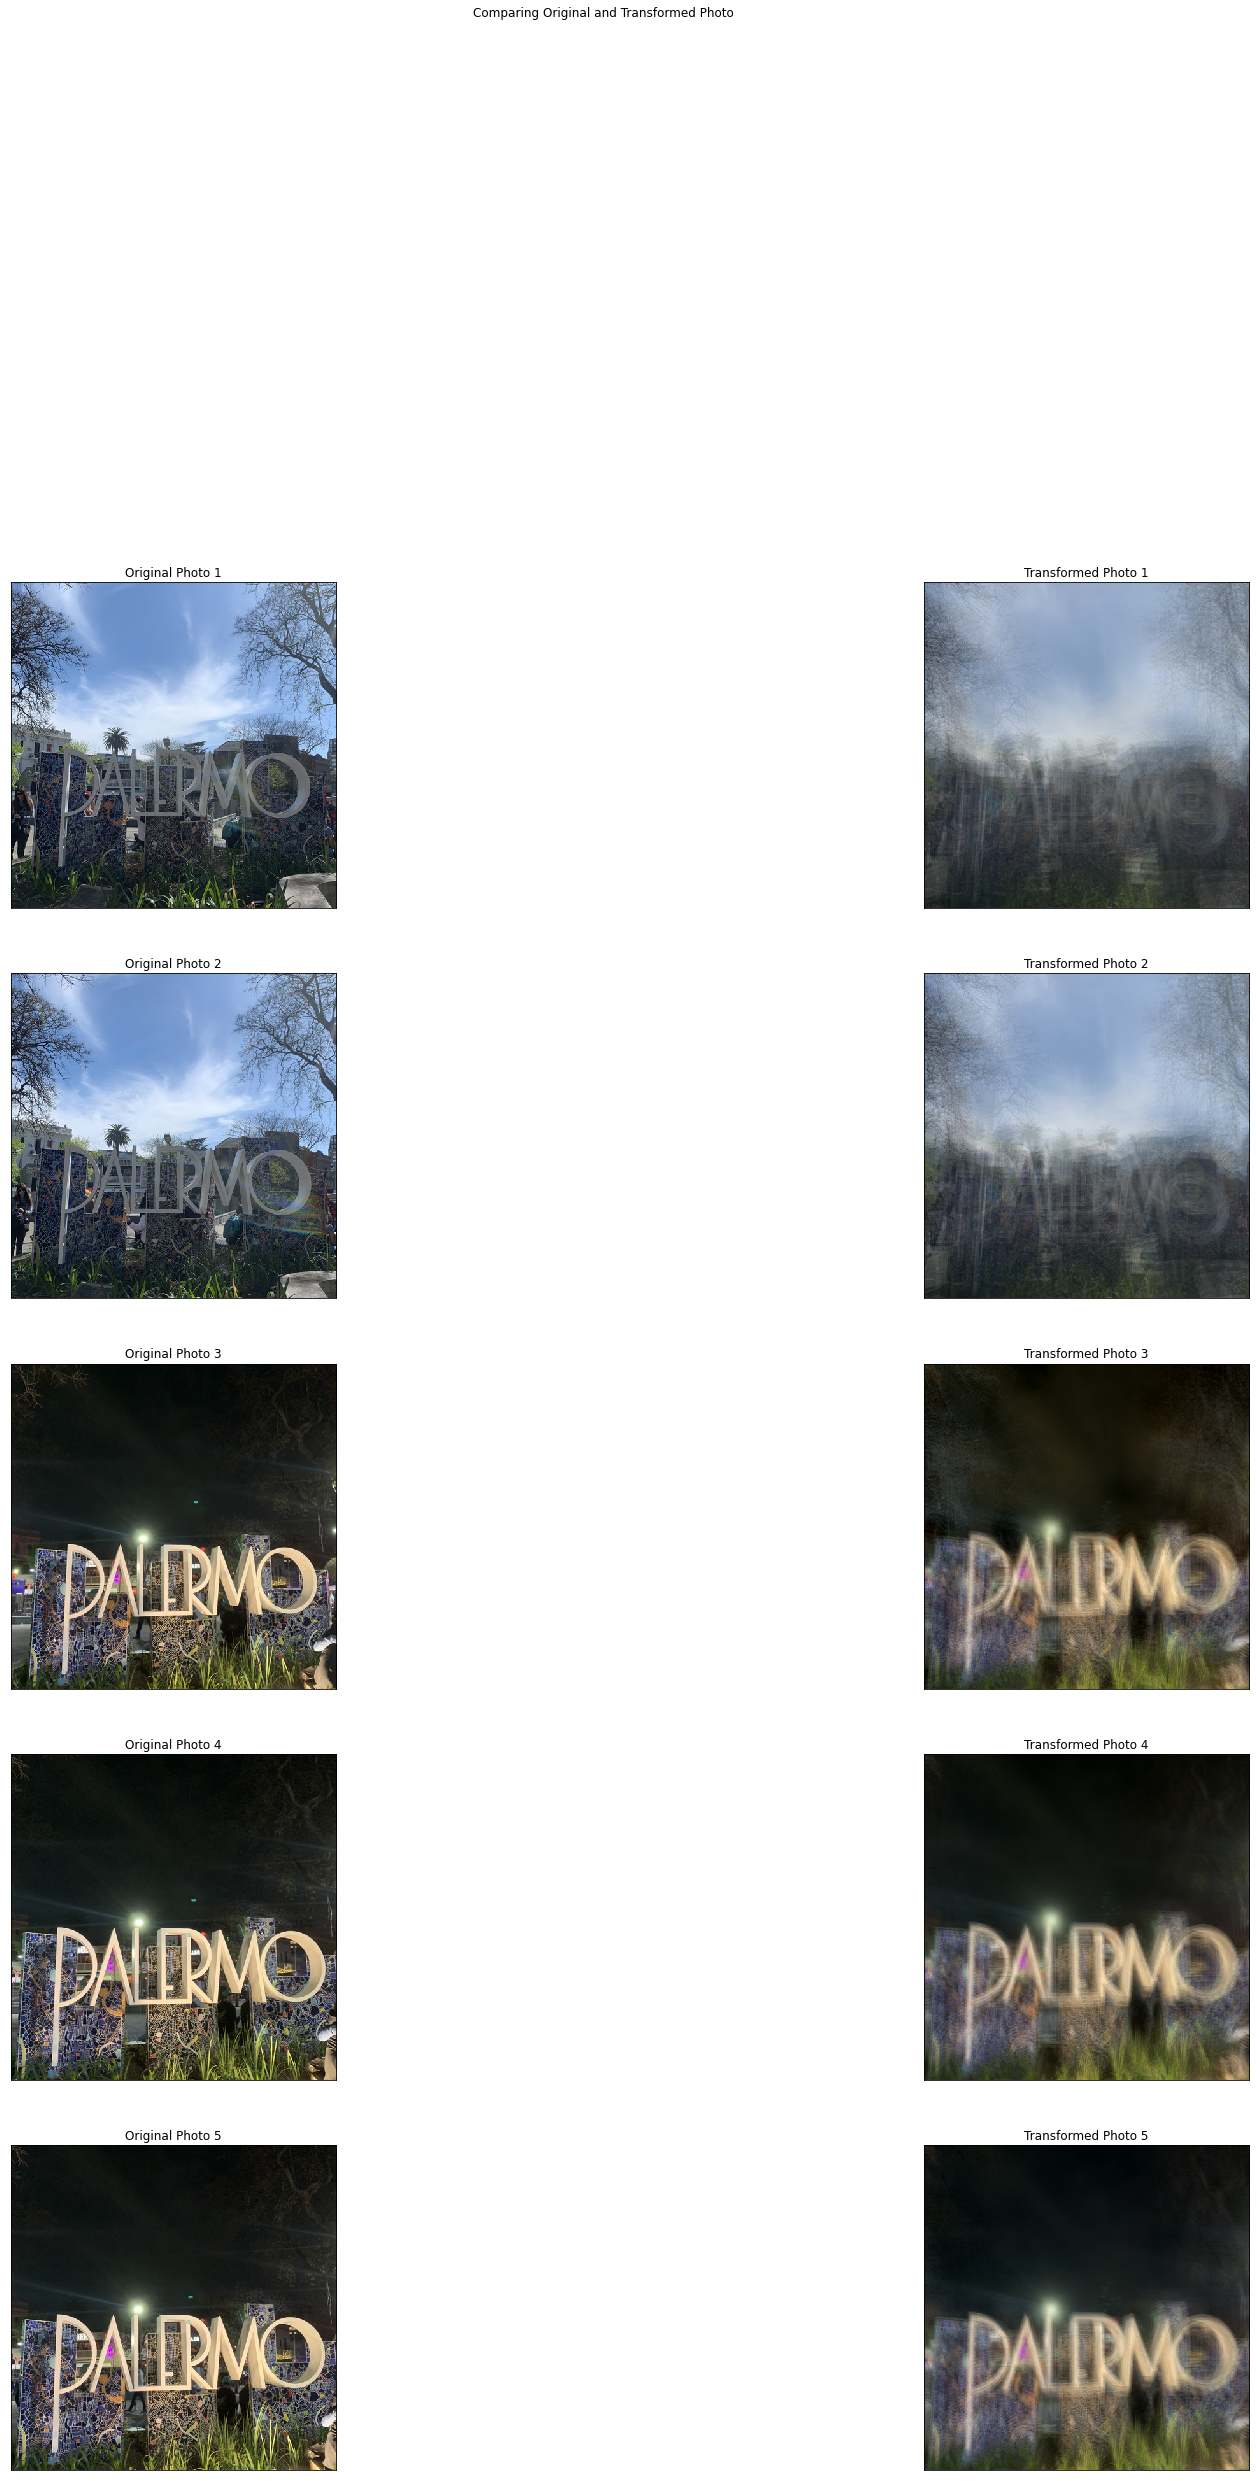

In [7]:
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(512,512,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(30, 200)) 

for i in range(10): 
    ax = fig.add_subplot(28, 2, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'{title[i]}')
    
plt.suptitle('Comparing Original and Transformed Photo', y=0.92)

plt.show()

## Comments
We can see a huge difference between the original and transformed photos. The transformed photos are much more blurry, which shows that 2 dimensions is not nearly enough to replicate the original photo. 

## **Show the reconstruction from each low-dimensional representation**

To show reconstruction from each low-dimensional representation, I did a two different re-constructions from dimension 1 to dimension 28. The first reconstruction chooses randomised photos, the second chooses the same photo in different dimensions.  

### Test 1: Randomised photos

In [8]:
# calculate PCA results and save image for each dimension
samples = []
expl_var = []
dims = []

for i in range(1,len(images)+1,1):
    
    # apply PCA
    pca = decomposition.PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(images)
    
    # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    # save one random sample from each dimension
    random_row = np.random.randint(len(images), size=1)
    sample = formatted[random_row]
    
    # calculate explained variance
    pca_var_expl = \
    np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)
    
    # save results
    samples.append(sample)    
    expl_var.append(pca_var_expl)
    dims.append(i)

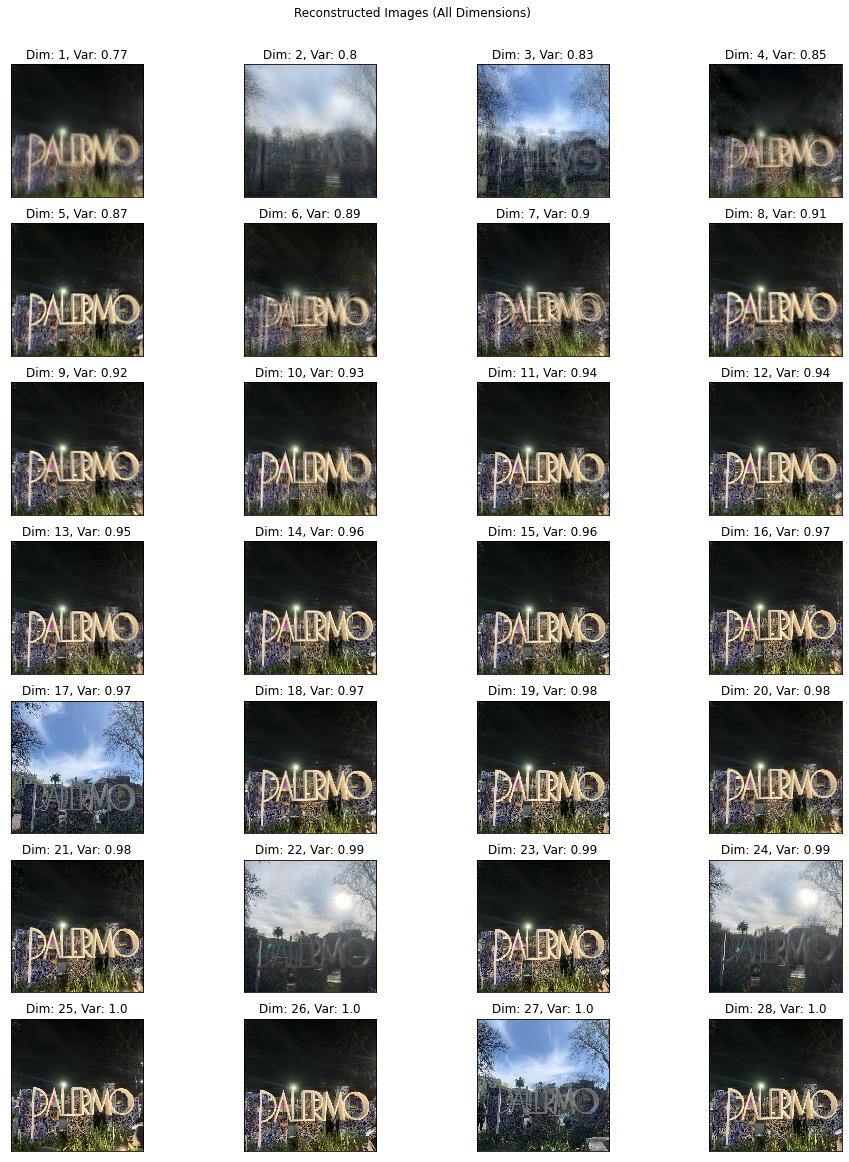

In [9]:
# plot sample from each dimension

# reshape formatted samples
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(512,512,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 20)) 

for i in range(len(samples)): 
    ax = fig.add_subplot(7, 4, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images (All Dimensions)', y=0.92)

plt.show()

### Test 2: Same photo
I tried to also only select the same sample from each dimension to see how the variations are explained as dimensions increase. 

In [10]:
# calculate PCA results and save image for each dimension

samples = []
expl_var = []
dims = []

for i in range(1,len(images)+1,1):
    
    # apply PCA
    pca = decomposition.PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(images)
    
    # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    # save one random sample from each dimension
#     random_row = np.random.randint(len(images), size=1)
    random_row = 3
    sample = formatted[random_row]
    
    # calculate explained variance
    pca_var_expl = \
    np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)
    
    # save results
    samples.append(sample)    
    expl_var.append(pca_var_expl)
    dims.append(i)

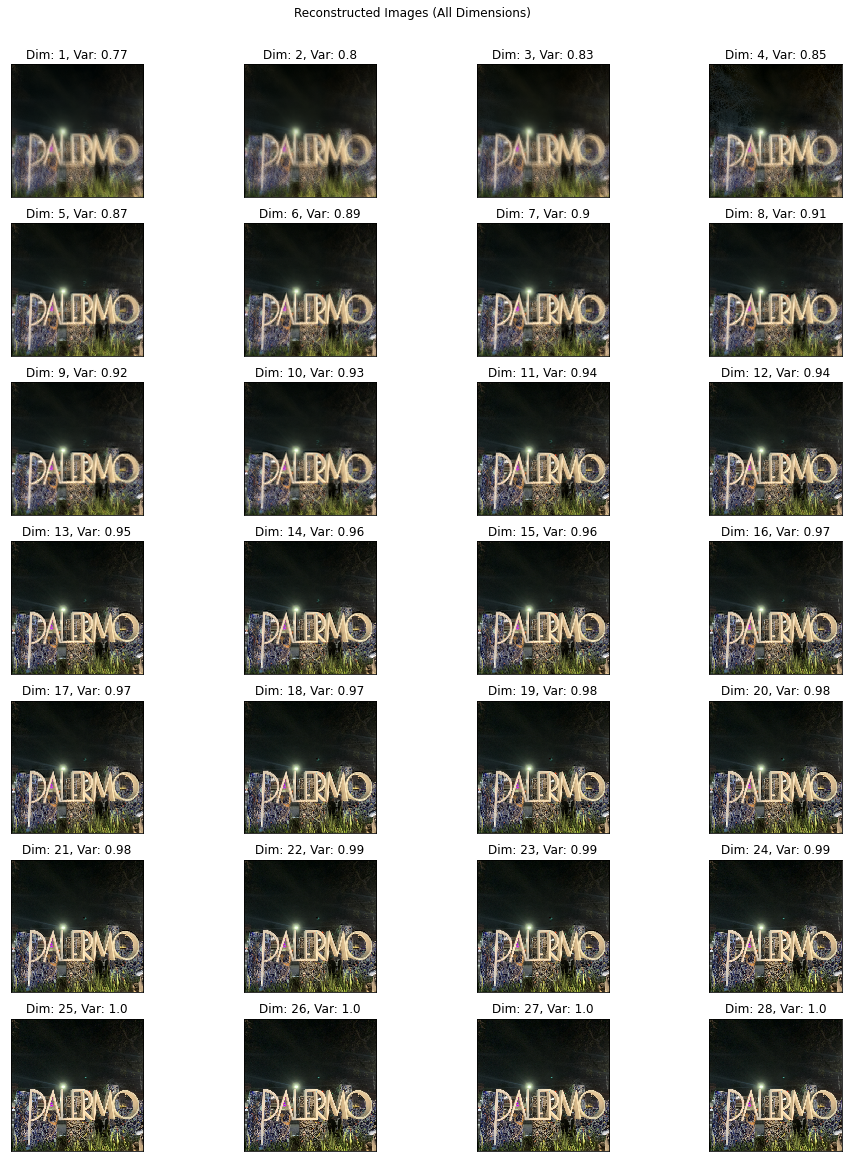

In [11]:
# plot sample from each dimension

# reshape formatted samples
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(512,512,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 20)) 

for i in range(len(samples)): 
    ax = fig.add_subplot(7, 4, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images (All Dimensions)', y=0.92)

plt.show()

## Comments

We can see that as we include more dimensions, the number of variations accounted for increases. At dimension 13, it accounted for 95% of the variations. This coincides with the plot created below. 

## **Finally, pick a point that is far away from any known location and plot its reconstruction**

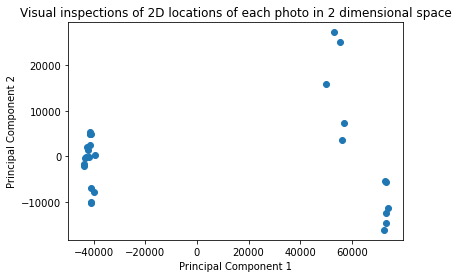

In [12]:
df = pd.DataFrame(transformed)
plt.scatter(df[0],df[1])
plt.title("Visual inspections of 2D locations of each photo in 2 dimensional space")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The images are not clustered in the same axes because I took it over a long period of time from 3pm to 8pm. It can be seen that points clustered on the left is taken during nighttime (around 8pm), and points taken during daytime ranges between PC2 value -10000 to 30000, and PC1 value at 60000. 

I have decided to pick the point at (0,0) that is far away from the two clusters. 

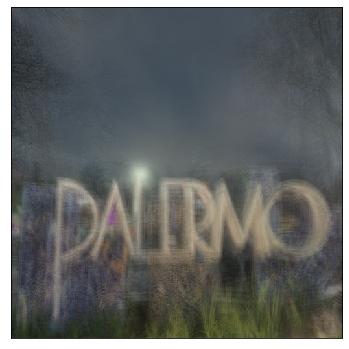

In [13]:
# apply PCA
pca = decomposition.PCA(n_components=2)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

 # transform image to the point PC1,PC2: [0,0]
inverse = pca.inverse_transform([0,0])
formatted = np.clip(inverse, 0, 255).astype(np.uint8)

new_img = Image.fromarray(formatted.reshape(512,512,3), 'RGB')

# plot samples
fig = plt.figure(figsize=(56, 50)) 

ax = fig.add_subplot(7, 4, 1, xticks=[], yticks=[]) 
ax.imshow(new_img, interpolation='nearest')

## Comments
This image is fascinating in a way that the background is both blue and black. The black on the sides probably come from night-time, and the tinted blue comes from daylight. The palermo sign is still clearly shown and there  is a rounded light above "L" that is present in night-time photos. Althought the photo is still rather blurry, it's still identifiable that it is the palermo street sign. 

To estimate what PC1 and PC2 signifies, 8 photos are printed for each 20000 PC1 and PC2 values. 

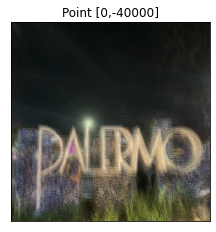

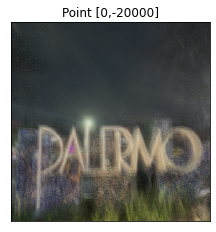

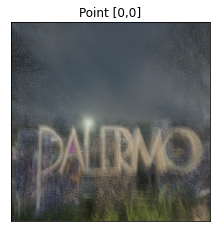

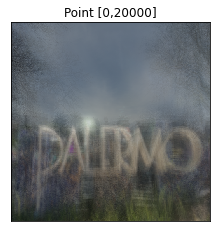

In [14]:
# apply PCA
pca = decomposition.PCA(n_components=2)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

for i in range(-40000,40000,20000):
 # transform image to the point PC1,PC2: [0,0]
    inverse = pca.inverse_transform([i,0])
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)

    new_img = Image.fromarray(formatted.reshape(512,512,3), 'RGB')

    # plot samples
    fig = plt.figure(figsize=(36, 30)) 

    ax = fig.add_subplot(7, 4, 1, xticks=[], yticks=[]) 
    plt.title(f"Point [0,{i}]")
    ax.imshow(new_img, interpolation='nearest')

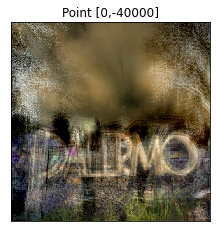

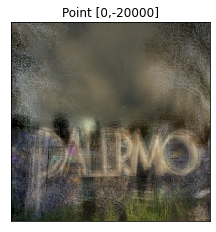

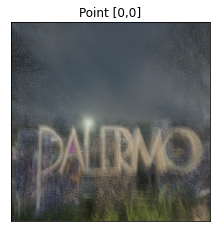

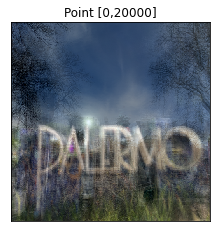

In [15]:
# apply PCA
pca = decomposition.PCA(n_components=2)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

for i in range(-40000,40000,20000):
 # transform image to the point PC1,PC2: [0,0]
    inverse = pca.inverse_transform([0,i])
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)

    new_img = Image.fromarray(formatted.reshape(512,512,3), 'RGB')

    # plot samples
    fig = plt.figure(figsize=(36, 30)) 

    ax = fig.add_subplot(7, 4, 1, xticks=[], yticks=[]) 
    plt.title(f"Point [0,{i}]")
    ax.imshow(new_img, interpolation='nearest')

It is deduced that PC1 measures constrast, when it reaches 30000 it has a low constrast, when reaches -40000, there is a high contrast. 

It is estimated that PC2 measures exposure, when it reaches 30000 it has a high exposure of blue, when reaches -40000, there is a high exposure of yellow. 

# **Extension**

## **Using the first few PCA components, train a linear regression model to predict the time of day the photos were taken (you can pull the timestamps directly from your phone to get your target feature).**


### Extract Timestamps with their image

In [16]:
# resize and crop images and extract Timmestamps
def resize_images(images):
    '''
    Resizes and crops images using the function given
    in the Session 7 repo from load_images.py.
    '''    

    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # EXTRACT TIMESTAMP
                Y = image._getexif()[36867]
                # resize the image to be more manageable
                image = PIL.ImageOps.exif_transpose(image)
                cover = resizeimage.resize_cover(image, [512,512])
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), Y))
                #find timestamp for image


    # Flatten it once more
    flattened = np.asarray(flattened)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    # return resized images
    return X, Y

# resize images using function
file = glob('palermo.image/*')
images,timestamp = resize_images(file)

/var/folders/cy/_ctynfc519bgs7b5np9zv9b00000gn/T/ipykernel_17107/1871662794.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flattened = np.asarray(flattened)
/Users/hugo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Apply PCA, Insert into dataframe with Timestamp

In [17]:
# apply PCA using all components
n_components = 2 #dimensions
pca = decomposition.PCA(n_components=n_components) #decomposes by n_components variables

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

#Shows first two PC values with timestamp
df = pd.DataFrame(transformed,timestamp)
df.reset_index(inplace=True)
df.columns = ['Timestamp', 'PC1', 'PC2']
df

Timestamp           PC1           PC2
0   2022:09:24 15:00:48  56314.708299   3655.048229
1   2022:09:24 15:00:47  57177.317879   7376.656975
2   2022:09:24 20:03:32 -40997.966303 -10148.816475
3   2022:09:24 20:03:44 -43812.833608  -2169.179912
4   2022:09:24 20:03:42 -42760.242123   2112.260263
5   2022:09:24 20:03:44 -43436.146188   -318.494152
6   2022:09:24 15:00:45  53191.944114  27260.132900
7   2022:09:24 20:03:33 -41289.962620 -10177.619807
8   2022:09:24 17:20:19  73080.123625 -14680.379610
9   2022:09:24 17:20:23  72579.657177 -16173.662273
10  2022:09:24 20:03:37 -41249.643928  -7063.168187
11  2022:09:24 15:00:44  55451.793528  25149.911541
12  2022:09:24 20:03:38 -42316.643111   1467.161395
13  2022:09:24 17:20:25  74060.381497 -11456.189056
14  2022:09:24 17:20:20  73420.377107 -12427.824162
15  2022:09:24 20:03:38 -41589.734152   4932.680274
16  2022:09:24 17:20:21  73036.414587  -5422.152316
17  2022:09:24 17:20:21  73169.973056  -5718.623714
18  2022:09:24 20:03:39 -41649.182386   4837.477205
19  2022:09:24 20:03:43 -41982.383899   -141.103870
20  2022:09:24 20:03:34 -39580.959514    321.795754
21  2022:09:24 20:03:40 -40989.820168   4815.888820
22  2022:09:24 20:03:45 -41485.317603   2394.754029
23  2022:09:24 15:01:03  49974.334740  15980.906465
24  2022:09:24 20:03:46 -42977.817882   -125.564646
25  2022:09:24 20:03:41 -41303.878513   5279.141127
26  2022:09:24 20:03:36 -40094.086519  -7853.466602
27  2022:09:24 20:03:43 -43940.407093  -1707.570195

## Perform Linear Regression

The timestamp extracted is tranformed into a float value for calculation. The datetime is only interpretable as a float value because datetime values can't be used for linear-regression in sklearn. 

## Plotting Linear Regression 
- **Evaluate these models using any of the performance metrics we've discussed in class and produce a visualization of their accuracy.**

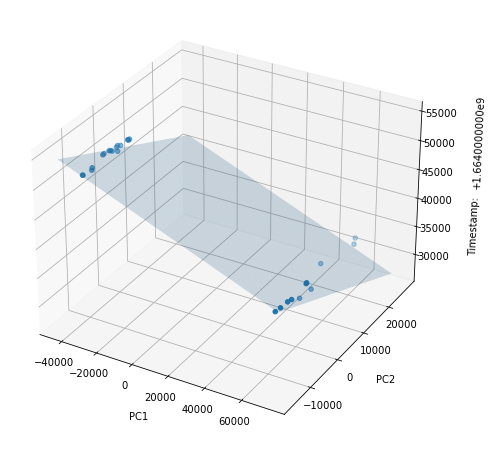

In [18]:
#Linear Regression here

import datetime as dt
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format = "%Y:%m:%d %H:%M:%S")

# Splitting the Dataset 
X = df.iloc[:,1:3]
y = df['Timestamp'].apply(lambda x: x.timestamp()) #Timestampped to a float value
#split training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 101)

# Instantiating LinearRegression() Model
lr = LinearRegression()

# Training/Fitting the Model
lr.fit(X_train, y_train)

# Making Predictions
pred = lr.predict(X_test)

#Plot figure
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111, projection='3d')

xdata = np.array(df['PC1'])
ydata = np.array(df['PC2'])
zdata = np.array(df['Timestamp'].apply(lambda x: x.timestamp()))

# generate a mesh
x_surf = np.linspace(min(X_train['PC1']),  max(X_train['PC1'])) 
y_surf = np.linspace(min(X_train['PC2']),  max(X_train['PC2']))  
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

z_surf=lr.coef_[0]*x_surf+lr.coef_[1]*y_surf+lr.intercept_
ax.plot_surface(x_surf, y_surf, z_surf, rstride=1, cstride=1, alpha=0.2)
ax.scatter3D(xdata, ydata, zdata)


ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('Timestamp:                          ', labelpad=15)


plt.show()

## Comments
The meshgrid above shows the values in 3 dimensions. We can see how different PC1 and PC2 values are fitted across a linear regression model, where low PC1and PC2 values generally have later timestamps (at night). high PC1 values generally have a earlier timestamp (morning), and is even earlier for data with a combination of high PC1 and PC2 values. 

## Finding Mean Absolute Error of the linear regression
- **Evaluate these models using any of the performance metrics we've discussed in class and produce a visualization of their accuracy.**

In [19]:
import datetime as dt
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format = "%Y:%m:%d %H:%M:%S")

# Splitting the Dataset 
X = df.iloc[:,1:3]
y = df['Timestamp'] 
#split training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 101)

# Instantiating LinearRegression() Model
lr = LinearRegression()

# Training/Fitting the Model
lr.fit(X_train, y_train)

# Making Predictions
pred = lr.predict(X_test)

#Converting into Timestamp variable
pred_timestamp = []
for i in pred:
    pred_timestamp.append(pd.Timestamp(i))

#Converting into Timestamp variable
y_test_timestamp = list(y_test)

def mean_absolute_error(y_test,pred):
    x = np.timedelta64(np.sum(abs(y_test-pred))/len(pred), 'ns')
    minutes = x.astype('timedelta64[m]')
    return minutes / np.timedelta64(1, 'm')

print('Mean Absolute Error:', mean_absolute_error(np.array(y_test_timestamp), np.array(pred_timestamp)),'minutes')


Mean Absolute Error: 30.0 minutes


## Comments
The mean absolute error of linear regression is found to be 30 minutes. This is not that bad of a mean absolute error if we are simply trying to differentiate whether the photo is taken during daytime or nighttime. It depends of the purpose behind the linear regression. Under that context, it is acceptable

## **Using the first few PCA components, train any of the classifiers we've used so far in class (using k-fold crossvalidation) to predict whether the photo was taken in the first half of the photos or in the second half of the photos.**

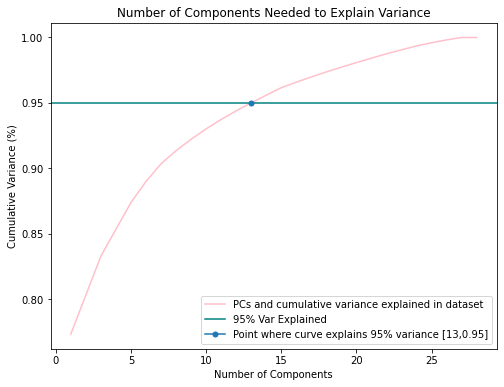

In [20]:
# apply PCA using all components
n_components = len(images) #dimensions
pca = decomposition.PCA(n_components=n_components) #decomposes by n_components variables

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

# plot number of components vs. explained variance
plt.figure(figsize=(8,6))

components = np.arange(1, n_components+1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, var, color='pink',label = "PCs and cumulative variance explained in dataset")
plt.axhline(y=0.95, color='teal', label='95% Var Explained')

plt.plot([13], [0.95], marker="o", markersize=5,label='Point where curve explains 95% variance [13,0.95]')

plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.legend(loc=4)
plt.show()


## Comments
The graph above shows that our photos require 13 components to explain 95% variance. Thus, maximum of 13 dimensions would be used for logistic regression classification. 

## Optimising Daytime VS Nighttime classification accuracy via CV of 1-13 dimensions 

I first wanted to see whether the model can differentiate between daytime and nighttime well. Dimensions from 1-13 are tried, and CV is performed for each of them to find the minimal amount of dimensions that can separate most of the data. 

In [21]:
def cv_daynight(images,timestamp):
    """
    Finds the dimension that gives the highest classification accuracy given by cross-validatiion score
    """
    dim, accuracy = 0,0
    for dimensions in np.arange(1,13):
        
        #PCA decomposition for each dimension
        pca = decomposition.PCA(n_components=n_components)
        transformed = pca.fit_transform(images)
        
        #Creating dataframe to put data in
        df = pd.DataFrame(transformed,timestamp)
        df.reset_index(inplace=True)
        df['index'] = pd.to_datetime(df['index'], format="%Y:%m:%d %H:%M:%S")
        
        #Sorting Dataframe by order of timestamp
        df = df.sort_values(by = ['index'])
        
        #Find photos taken in night-time
        df['Nighttime?'] = np.where(df['index']>= '2022-09-24 18:00:00', True, False)
        
        #Perform logistic regression
        X, y = df.iloc[:,1:dimensions+1],df["Nighttime?"]
        clf = LogisticRegression(random_state=0).fit(X, y)
        scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
        if np.mean(scores)> accuracy:
            dim = dimensions
            accuracy = np.mean(scores)
    return  "Accuracy: ",accuracy, "Dimension: ",dim

In [22]:
cv_daynight(images,timestamp)

('Accuracy: ', 1.0, 'Dimension: ', 1)

## Comments
It is found that even with one dimension with one principal component, the logistic regression model can clearly separate photos taken in day-time and night-time with 100% accuracy

## Optimising Firsthalf vs Secondhalf classification accuracy via CV of 1-13 dimensions 
I want to also see whether the logistic regression model can separate First half of the model from the second half. 

In [28]:
@ignore_warnings
def cv_firsthalf(images,timestamp):
    """
    Finds the dimension that gives the highest classification accuracy given by cross-validatiion score
    """
    dim, accuracy = 0,0
    for dimensions in np.arange(1,13):
        
        #PCA decomposition for each dimension
        pca = decomposition.PCA(n_components=n_components)
        transformed = pca.fit_transform(images)
        
        #Creating dataframe to put data in
        df = pd.DataFrame(transformed,timestamp)
        df.reset_index(inplace=True)
        df['index'] = pd.to_datetime(df['index'], format="%Y:%m:%d %H:%M:%S")
        
        #Sorting Dataframe by order of timestamp
        df = df.sort_values(by = ['index'])
        
        #Find photos taken in night-time
        df['FirstHalf?'] = np.where(df['index']>= '2022-09-24 20:03:36', False,True)
        
        #Perform logistic regression
        X, y = df.iloc[:,1:dimensions+1],df["FirstHalf?"]
        clf = LogisticRegression(random_state=0).fit(X, y)
        scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
        if np.mean(scores)> accuracy:
            dim = dimensions
            accuracy = np.mean(scores)
    return  "Accuracy: ",accuracy, "Dimension: ",dim

In [29]:
cv_firsthalf(images,timestamp)

('Accuracy: ', 0.9666666666666668, 'Dimension: ', 7)

Using the cross validation score, it is found that using 7 dimensions has the highest accuracy of 0.967. This determines for us how many components we should use for logistic regression. 

**Evaluate these models using any of the performance metrics we've discussed in class and produce a visualization of their accuracy.**

In [25]:
# apply PCA using all components
n_components = 7 #dimensions
pca = decomposition.PCA(n_components=n_components) #decomposes by n_components variables

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)

X, y = transformed,timestamp
clf = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(clf.score(X, y))

0.8214285714285714


/Users/hugo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This shows that logistic regression has a score of 0.7857 given 7 dimensions. 